In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def generate_cluster(n=100, mu1=0, sigma1=0.5, mu2=0, sigma2=0.5):
    # generate cluster having normal distribution
    return np.array([np.random.normal(mu1, sigma1, n), 
                    np.random.normal(mu2, sigma2, n)])

In [3]:
def dist(p1, p2):
    # Euclidean distance between p1 and p2 points
    return np.sqrt(np.sum((p1-p2)**2))

In [4]:
def get_distances(p, data):
    return np.array([dist(p, dp) for dp in data])

In [5]:
def distance_matrix(data):
    # data rows are points, data columns are their coordinates
    return {(k1, k2):dist(v1, v2) for k2, v2 in data.items()
                     for k1, v1 in data.items()}

In [6]:
def k_means(data, n_clusters):
    # TODO: придумать лучшее начальное приближение центров 
    as_dict = {i:data[i] for i in range(data.shape[0])}
    
    # initial
    distances = dict(sorted(distance_matrix(as_dict).items(), 
                            key=lambda x: x[1], reverse=True))
    centers = {}
    cnt = 0
    for key in distances:
        for item in key:
            if item not in centers:
                centers[item] = as_dict[item]
                cnt += 1
                if cnt == n_clusters:
                    break
        if cnt == n_clusters:
            break
    centers = dict(sorted(centers.items(), key=lambda x: x[0]))
    
    # iterations
    centers = [value for value in centers.values()]
    clusters = [[] for i in range(len(centers))]
    while True:
        clusters = [[] for i in range(len(centers))]
        for point in data:
            index = np.argmin(get_distances(point, centers))
            clusters[index].append(point)
        new_centers = []
        for i in range(len(centers)):
            new_centers.append(np.sum(np.array(clusters[i]), axis=0) / len(clusters[i]))
        if abs(sum((sum(centers)))-sum(sum(new_centers))) <= 1e-3:
            break
        centers = new_centers[:]
    return np.array([np.array(cluster) for cluster in clusters]) , centers

In [50]:
def get_colors(clusters, real_clusters, colors):
    new_colors = [[] for i in range(len(clusters))]
    for i in range(len(clusters)):
        for point in clusters[i]:
            new_colors[i].append(colors[i]) if point in real_clusters[i] \
                else new_colors[i].append('orange')
    return new_colors

In [8]:
def sup(data):
    # data rows are points, data columns are their coordinates
    len_diff = lambda x, y: abs(x.shape[0]-y.shape[0])
    indicies_min = lambda x: np.unravel_index(np.argmin(x, axis=None), x.shape)
    graph = np.zeros([data.shape[0], data.shape[0]])
    as_dict = {i:data[i] for i in range(data.shape[0])}
    marked_distances = []
    isolated_points = [i for i in range(data.shape[0])]
    while isolated_points:
        distances = distance_matrix(unprocessed)
        

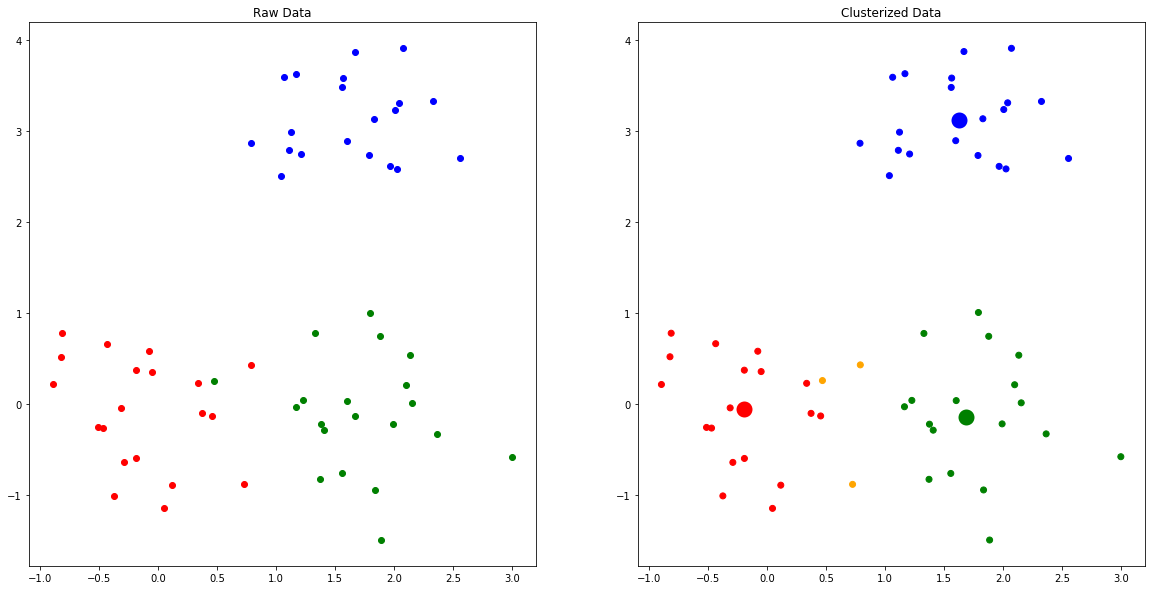

In [58]:
colors = ['red', 'green', 'blue']
cluster = generate_cluster(20)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax1.scatter(cluster[0], cluster[1], c=colors[0])

cluster1 = generate_cluster(20, mu1=1.5, sigma1=0.5, mu2=0, sigma2=0.5)
ax1.scatter(cluster1[0], cluster1[1], c=colors[1])

cluster2 = generate_cluster(20, mu1=1.5, sigma1=0.5, mu2=3, sigma2=0.5)
ax1.scatter(cluster2[0], cluster2[1], c=colors[2])
ax1.set_title('Raw Data')

data = np.concatenate((cluster.T, cluster1.T, cluster2.T))

clusters = k_means(data, 3)
new_colors = get_colors(clusters[0], [cluster.T, cluster1.T, cluster2.T], colors)
for i in range(len(clusters[0])):
    ax2.scatter(clusters[0][i].T[0], clusters[0][i].T[1], c=new_colors[i])

for i in range(len(clusters[1])):
    ax2.scatter(clusters[1][i][0], clusters[1][i][1], linewidths=10, c=colors[i])
ax2.set_title('Clusterized Data')
plt.show()